# Tutorial 1: 10X Visium dataset (DLPFC)

Here, we use sample id 151673 from DLPFC dataset  to demostrate the performance of GraphPCA. can be downloaded from their original study spatialLIBD(https://research.libd.org/spatialLIBD/index.html).  

## Load packages

In [1]:
import GraphPCA as sg
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import squidpy as sq
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances as pair
from sklearn.metrics import adjusted_rand_score as ari_score

## Setting parameters

In [2]:

samples = ["151507", "151508", "151509", "151510", "151669", "151670",
           "151671", "151672", "151673", "151674", "151675", "151676"]
BestK=[7,7,7,7,5,5,5,5,7,7,7,7]
data_path = "../../data/DLPFC/"
save_path = "../../results/DLPFC/"
path_GT = "../../data/DLPFC/groundtruth/SpatialDE_clustering/cluster_labels_"
sample_id = 8
PCA_components = 50

## Preprocessing

Before performing GraphPCA, we assumed that the gene expression counts have already been preprocessed with analytic Pearson residuals proposed by [Lause et al.](https://scanpy-tutorials.readthedocs.io/en/latest/tutorial_pearson_residuals.html) and further scaled for each gene to have 0 mean and unit standard deviation. Then, we selected the top 3,000 spatial variable genes using SPARK package.

In [3]:
adata = sc.read(data_path + samples[sample_id] + "/sample_data.h5ad")
sc.pp.filter_genes(adata,min_cells=20)
sc.experimental.pp.normalize_pearson_residuals(adata)
sc.pp.scale(adata)
SVG_list = pd.read_csv("../../results/DLPFC/SpatialPCA_data_preprocess/" + samples[sample_id] + "_SVGs.csv",index_col=0)
adata = adata[:,adata.var.gene_ids.isin(SVG_list.x)]    

## Perform GraphPCA

In [4]:
groundtruth=pd.read_csv(path_GT+samples[sample_id]+".csv", sep=",",header=0,na_filter=False,index_col=0) 
groundtruth=np.array(groundtruth["ground_truth"])
adata.obs["groundtruth"] = groundtruth

x_array=adata.obs["array_row"].tolist()
y_array=adata.obs["array_col"].tolist()
location=np.array([x_array, y_array]).T.astype(np.float32)

Z,W = sg.Run_GPCA(adata, location=location, n_components = 50, method = "knn", platform = "Visium", _lambda =0.5,
                save_reconstruction=True)
adata.obsm["GraphPCA"] = Z
print(Z.shape)

(3639, 50)


## Clustering

In [5]:
estimator = KMeans(n_clusters=BestK[sample_id])
res = estimator.fit(Z[:,:])
lable_pred=res.labels_
adata.obs["GPCA_pred"]= lable_pred
adata.obs["GPCA_pred"] = adata.obs["GPCA_pred"].astype('category')
refined_pred=sg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["GPCA_pred"].tolist(), dis= pair(location), shape="hexagon")
adata.obs["GPCA_pred"]= refined_pred
adata.obs["GPCA_pred"] = adata.obs["GPCA_pred"].astype('category')
print(ari_score(adata.obs.GPCA_pred,adata.obs.groundtruth))

0.5311286908464182


## Visualization

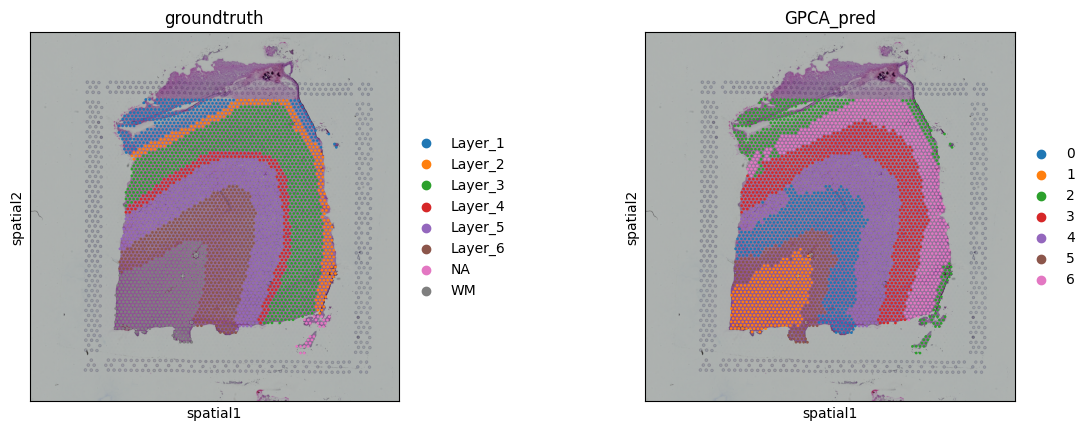

In [6]:
sq.pl.spatial_scatter(adata, color=["groundtruth","GPCA_pred"])

## Denosing

In [7]:
adata

AnnData object with n_obs × n_vars = 3639 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'groundtruth', 'GPCA_pred'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'pearson_residuals_normalization', 'groundtruth_colors', 'GPCA_pred_colors'
    obsm: 'spatial', 'GraphPCA'
    layers: 'GraphPCA_ReX'

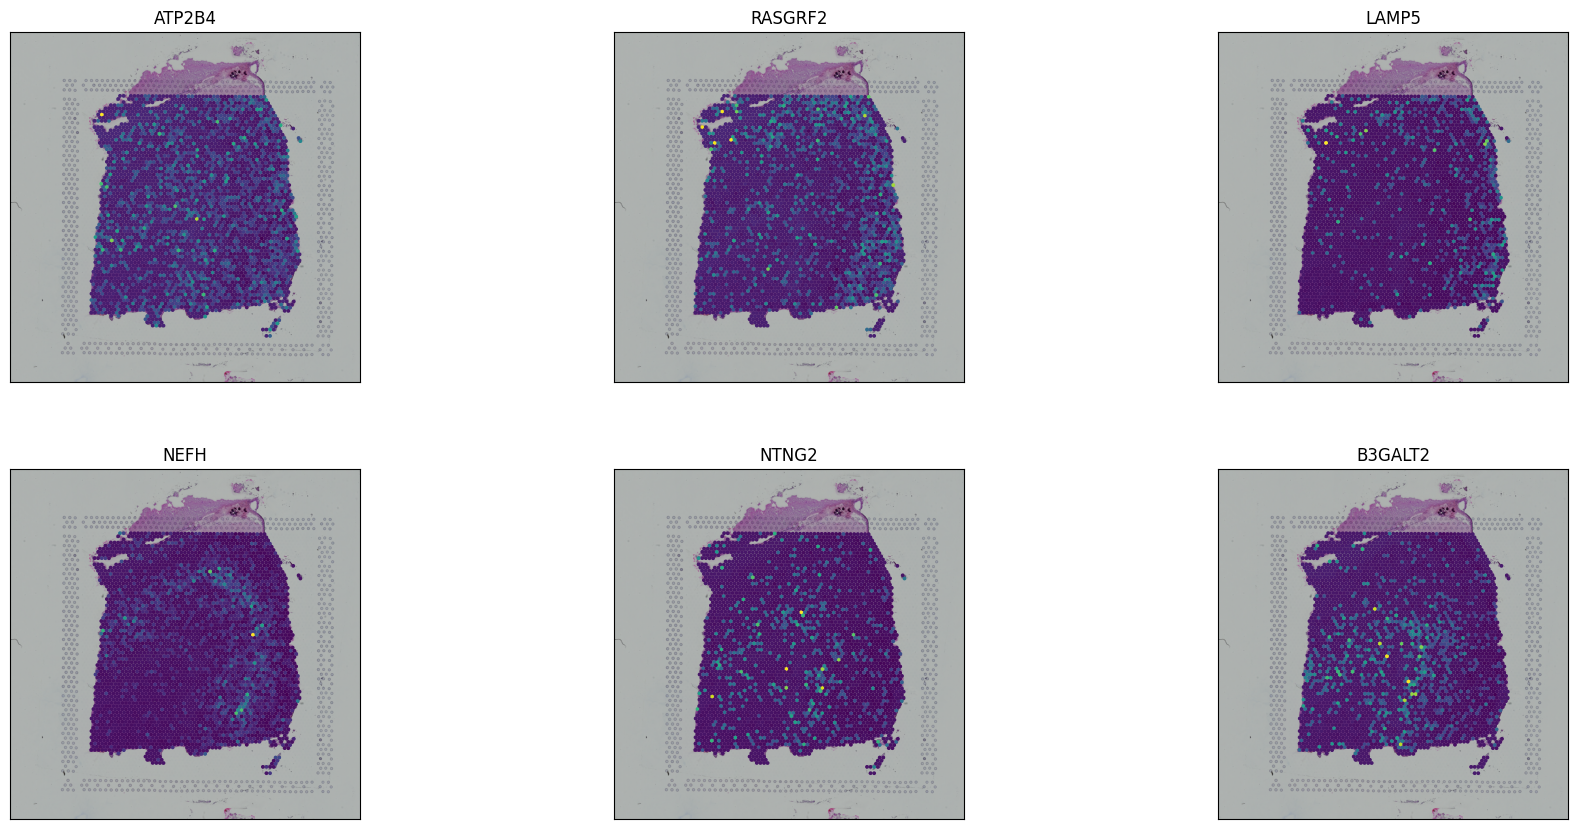

In [8]:
sq.pl.spatial_scatter(adata,color=["ATP2B4","RASGRF2","LAMP5","NEFH","NTNG2","B3GALT2"],
                      ncols=3,axis_label=["",""],size=1.5,colorbar =False)

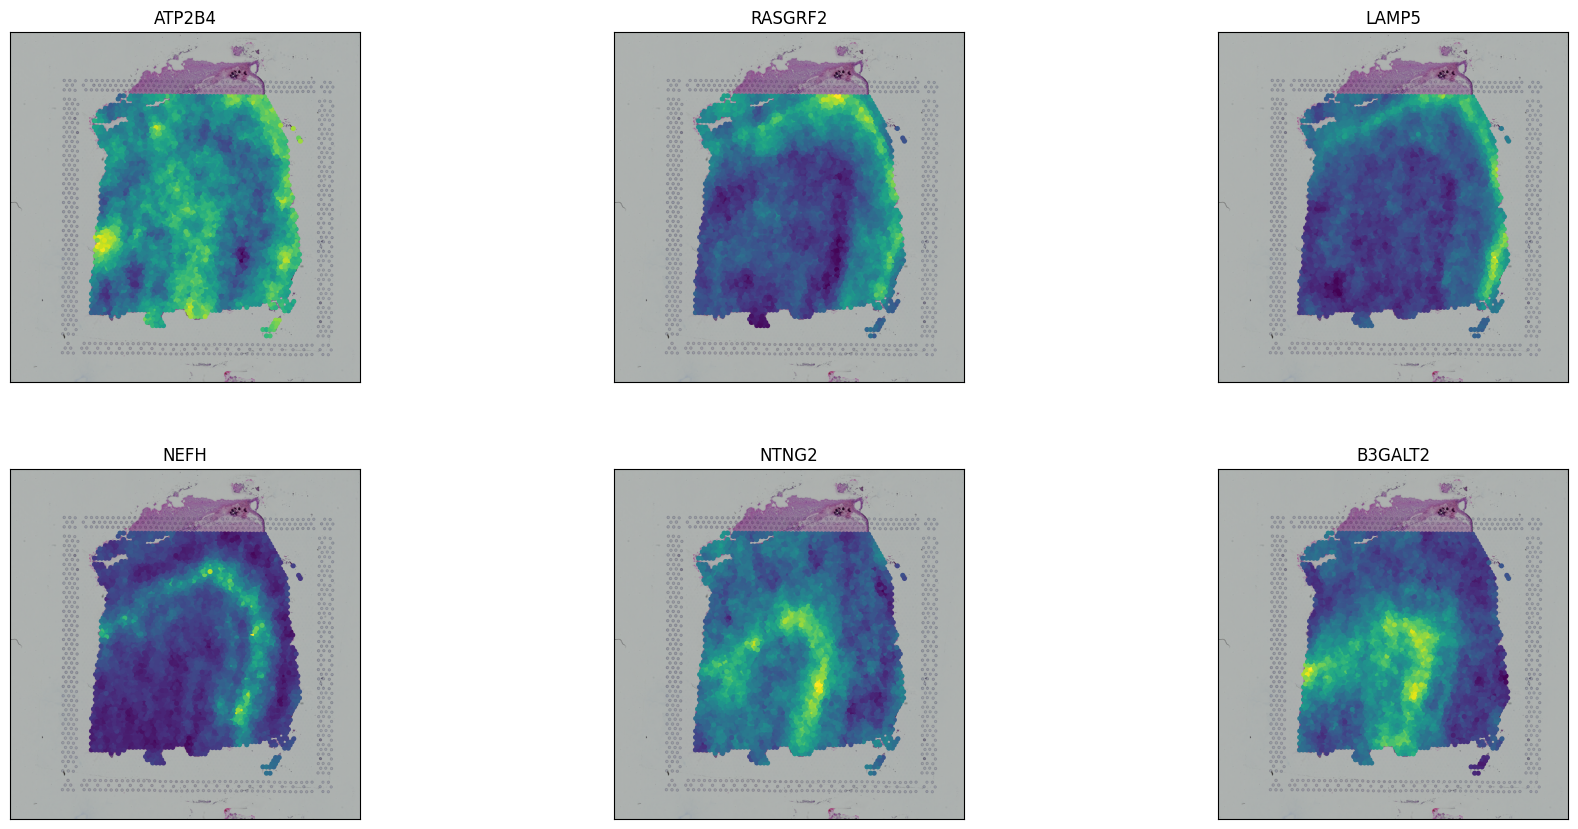

In [9]:
sq.pl.spatial_scatter(adata,color=["ATP2B4","RASGRF2","LAMP5","NEFH","NTNG2","B3GALT2"],
                      ncols=3,axis_label=["",""],size=2,colorbar =False,layer="GraphPCA_ReX")

In [10]:
adata = adata[adata.obs.groundtruth!="NA",:]

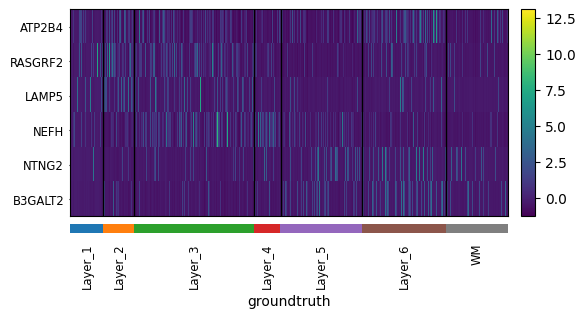

In [11]:
sc.pl.heatmap(adata, var_names=["ATP2B4","RASGRF2","LAMP5","NEFH","NTNG2","B3GALT2"], 
              groupby='groundtruth', cmap='viridis', dendrogram=False,swap_axes=True,
              figsize=(6,3))


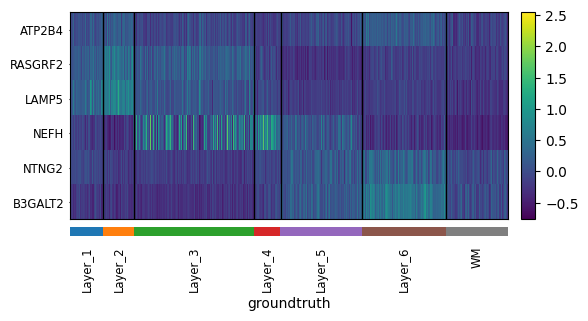

In [13]:
sc.pl.heatmap(adata, var_names=["ATP2B4","RASGRF2","LAMP5","NEFH","NTNG2","B3GALT2"], 
              groupby='groundtruth', cmap='viridis', dendrogram=False,swap_axes=True,
              figsize=(6,3),layer="GraphPCA_ReX")


## Coexpression module

In [14]:
GPCA_pcs = pd.DataFrame(adata.obsm["GraphPCA"])
GPCA_pcs.index = adata.to_df().index
GPCA_pcs.columns = [ "PC_" + str(i) for i in np.arange(GPCA_pcs.shape[1]) ]

In [15]:
adata.obs = pd.concat([adata.obs,GPCA_pcs],axis=1)

In [16]:
sc.set_figure_params( color_map = 'viridis',figsize=(5,5))

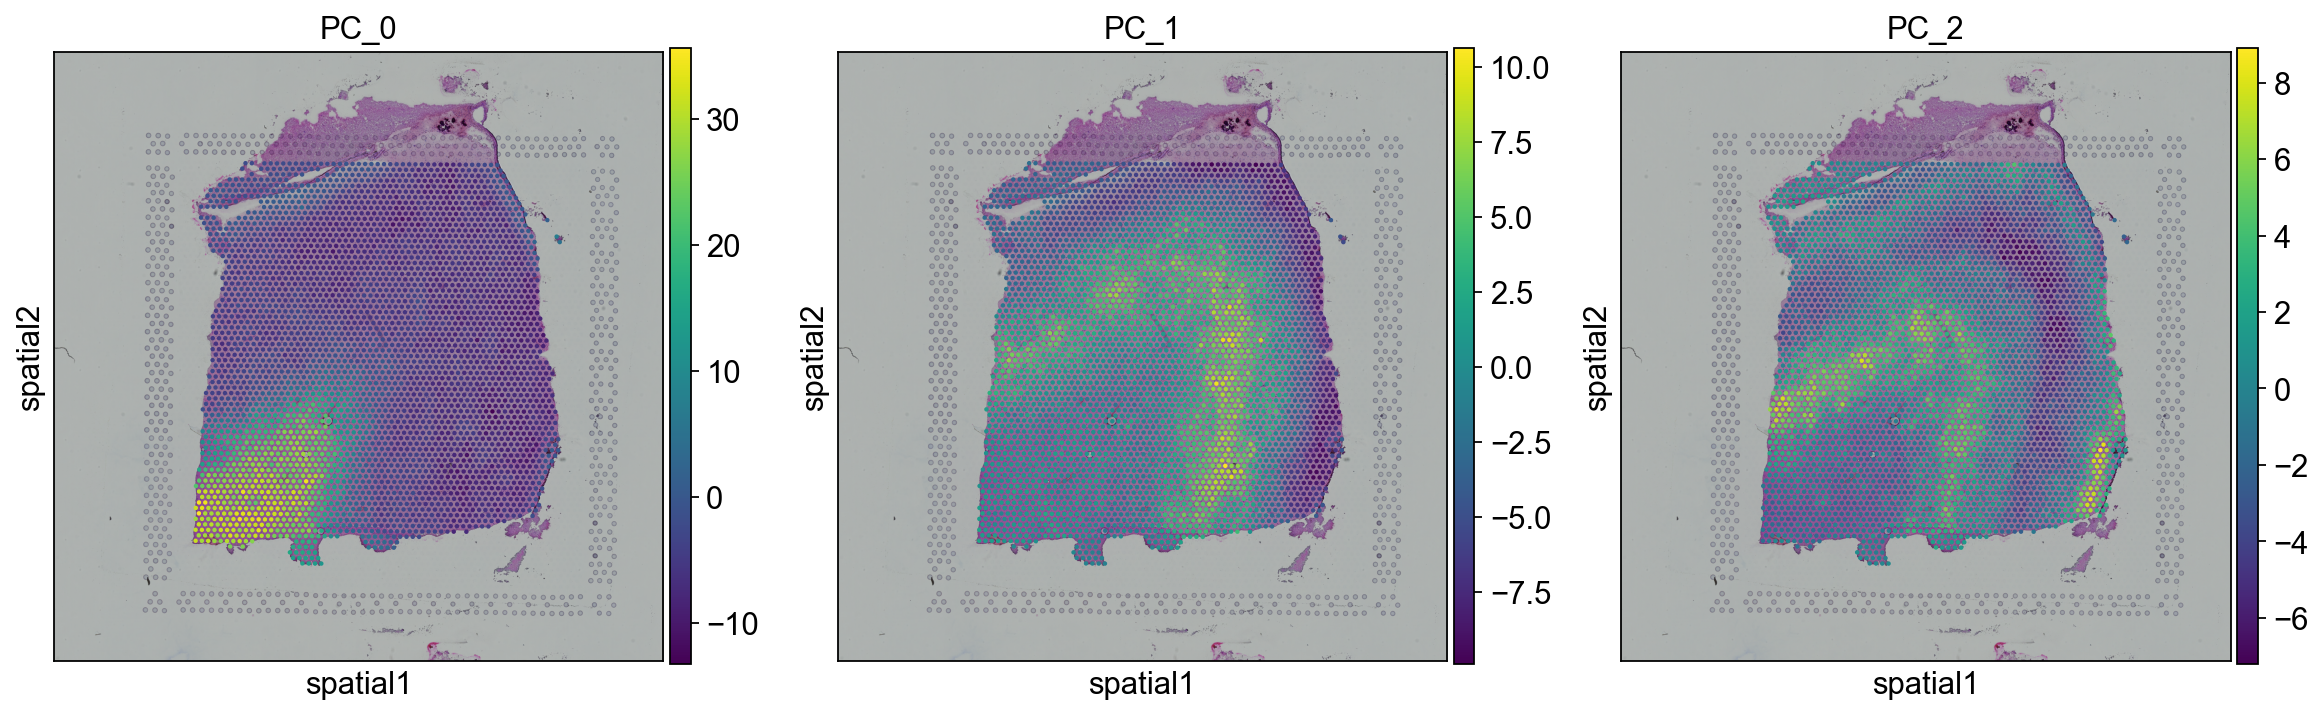

In [17]:
sq.pl.spatial_scatter(adata,color=["PC_0","PC_1","PC_2"])

In [18]:
GPCA_w = pd.DataFrame(W)
GPCA_w.index = adata.to_df().columns
GPCA_w.columns = [ "PC_" + str(i) for i in np.arange(GPCA_w.shape[1]) ]

In [19]:
top_5_rows = {}
for column in GPCA_w.columns:
    top_5_rows[column] = GPCA_w.nlargest(5, column).index.tolist()

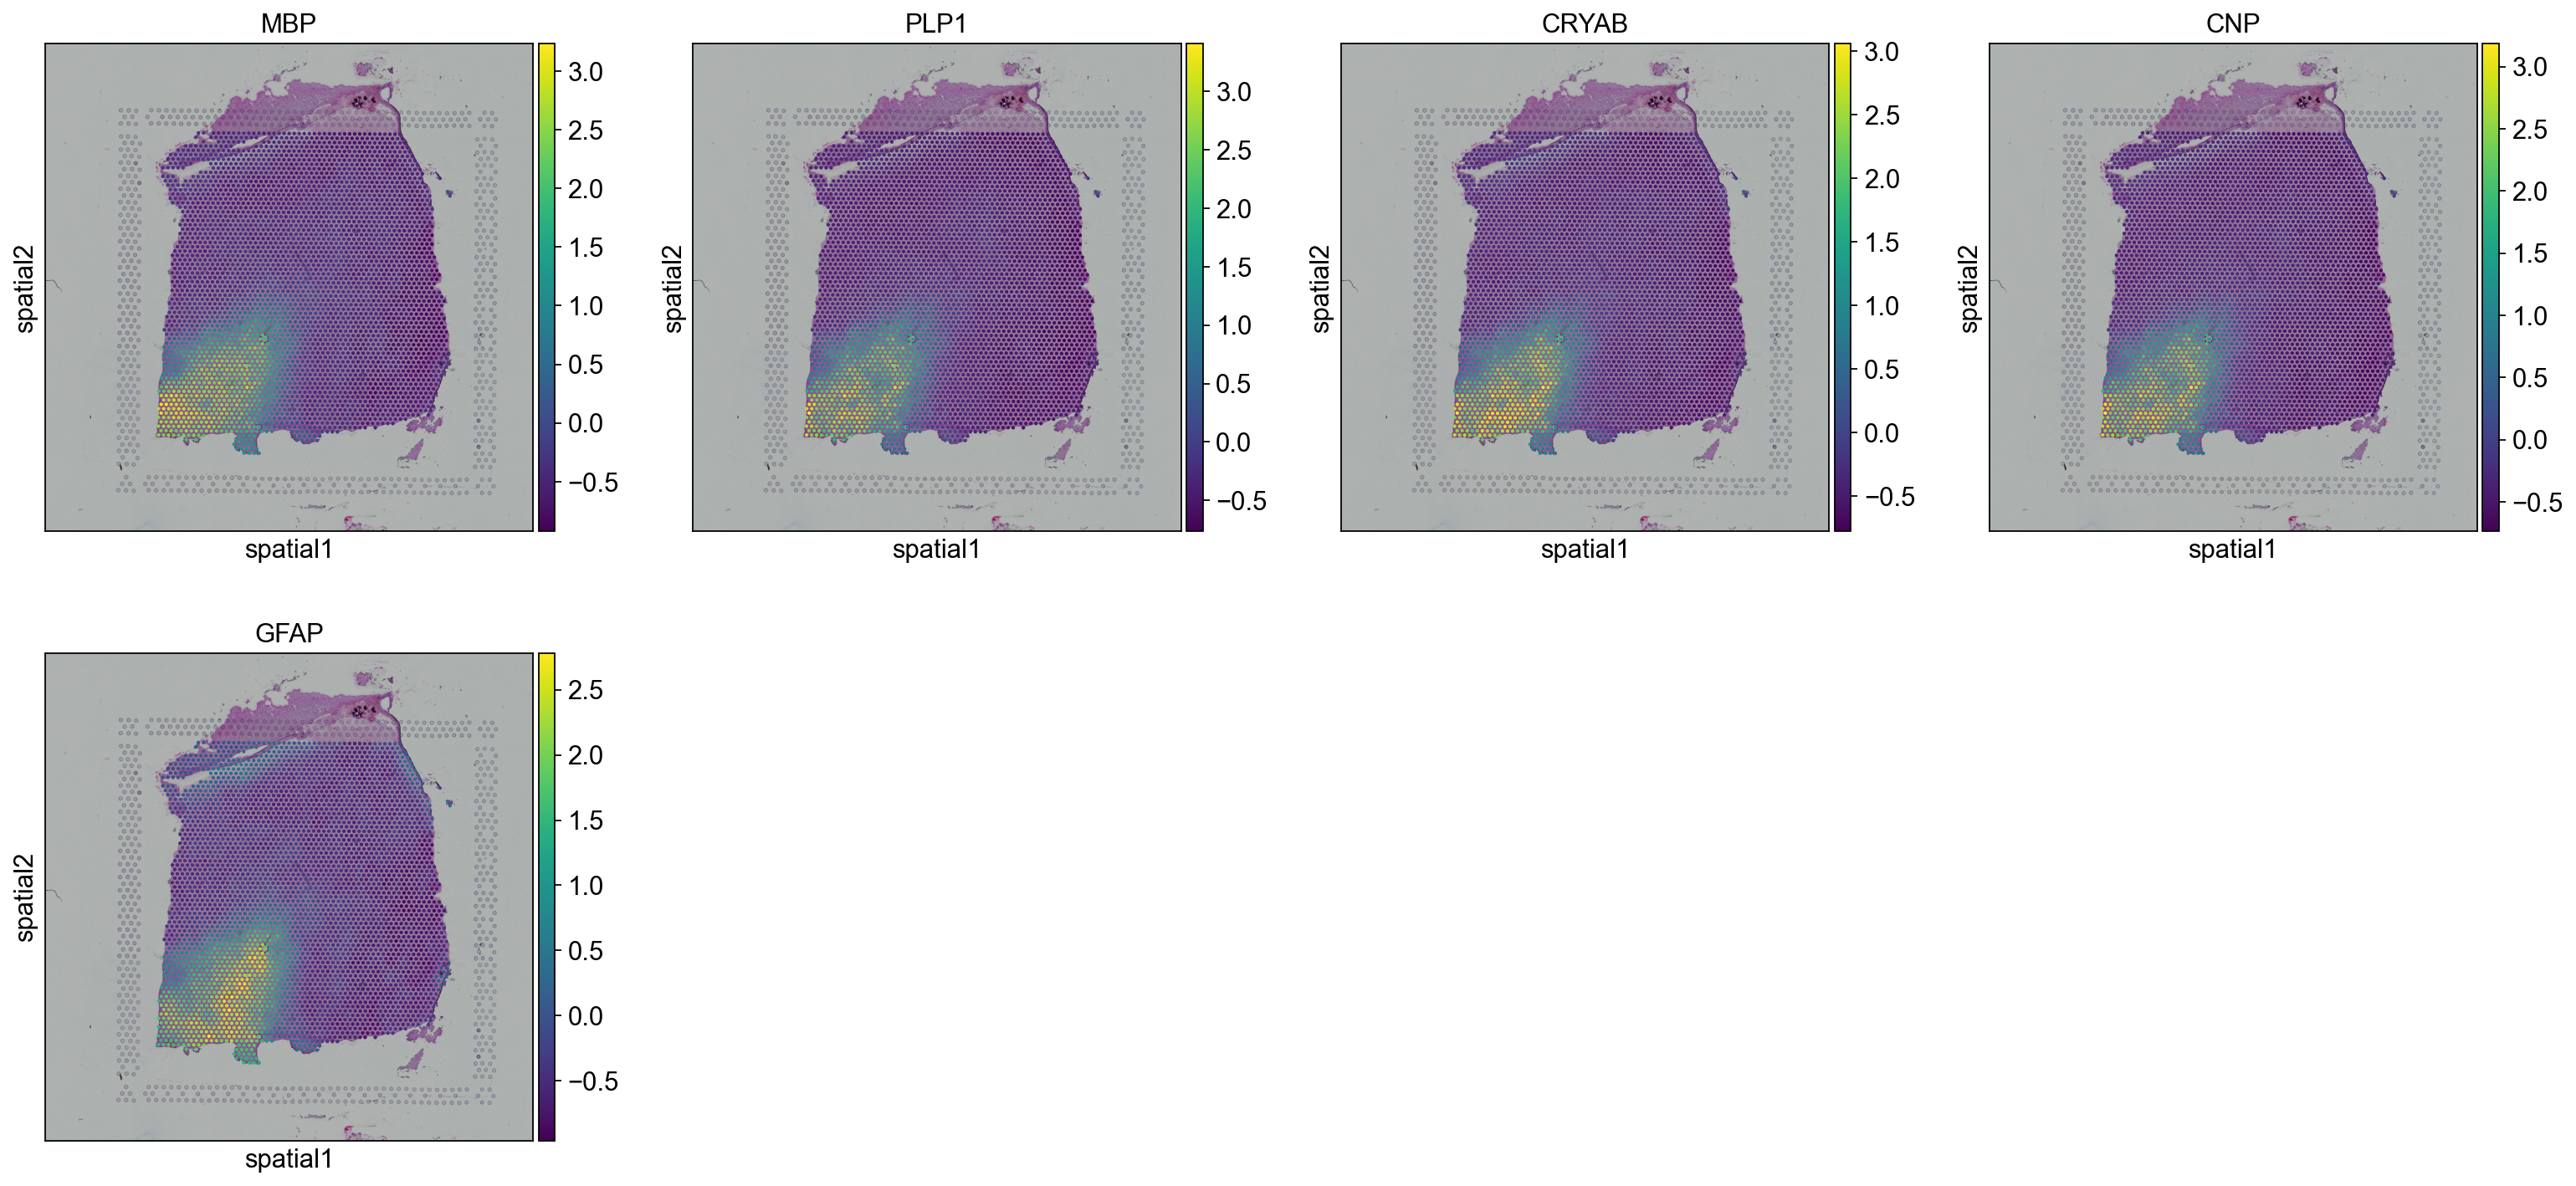

In [20]:
sq.pl.spatial_scatter(adata,color=top_5_rows["PC_0"],layer="GraphPCA_ReX")